Epoch 0, Loss (RMSE): 0.3406
Epoch 100, Loss (RMSE): 0.1574
Epoch 200, Loss (RMSE): 0.1008
Epoch 300, Loss (RMSE): 0.0862
Epoch 400, Loss (RMSE): 0.0827
Epoch 500, Loss (RMSE): 0.0823


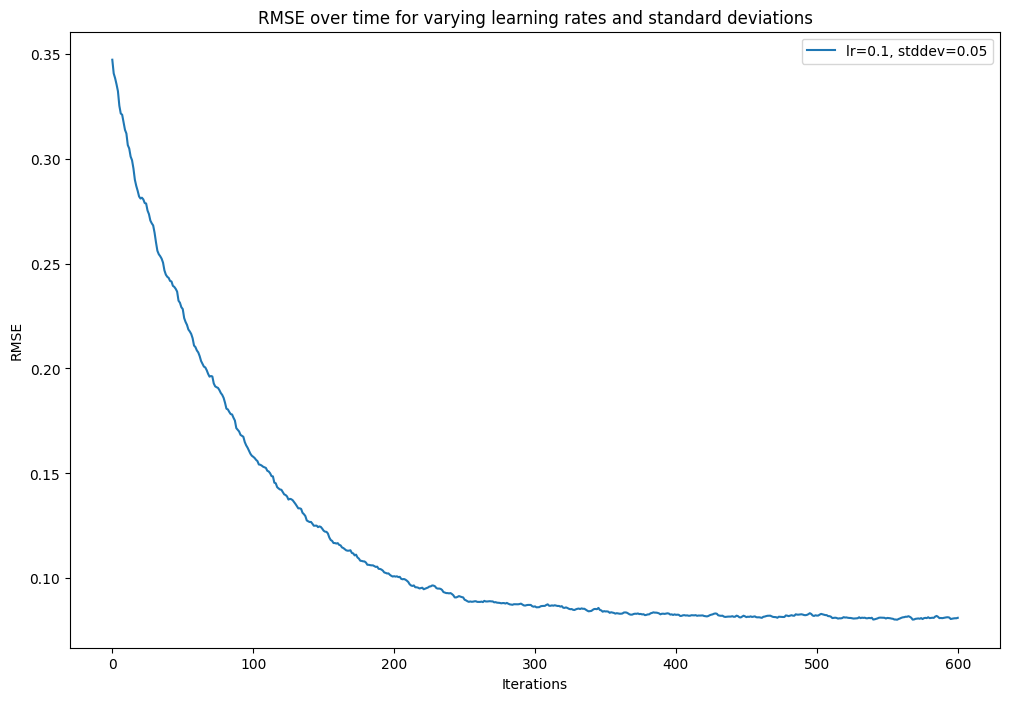

In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Configuration parameters
num_users = 8
num_movies = 8
latent_dim = 8  # Latent vector length
epochs = 600
stddev = 0.400001  # Standard deviation for noise in true rating
learning_rate = 0.01  # How fast to move latent vectors

m = list(range(10))
def normalize(vectors):
    norms = tf.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

# Initialize latent vectors for users and movies
starting_user_latent = tf.Variable( normalize(tf.random.uniform((num_users, latent_dim), minval=0, maxval=1, dtype='float32')))
starting_movie_latent = tf.Variable( normalize(tf.random.uniform((num_movies, latent_dim), minval=0, maxval=1, dtype='float32')))
# print(user_latent)
# print(movie_latent)
# movie_latent = normalize(tf.Variable(tf.random.normal((num_users, latent_dim), dtype='float32')))


# row_norms = tf.norm(user_latent, axis=1, keepdims=True)
# user_latent.assign(user_latent / row_norms)

# print(10)
# # user_latent[0].assign([1, 2, 3])
# print(user_latent)
# test = tf.Variable(user_latent[0]);
# test2 = user_latent[0];
# test.assign()
# movie_latent = tf.Variable(tf.random.normal((num_movies, latent_dim), dtype='float32'))
# print(tf.variable)

# Normalize the latent vectors to ensure they are unit vectors

# Create a random true rating matrix between 0 and 1
true_ratings = tf.random.uniform((num_users, num_movies), minval=0, maxval=1, dtype='float32')

# RMSE function to calculate root mean squared error between true and predicted ratings
def calculate_rmse(true_ratings, predicted_ratings):
    return tf.sqrt(tf.reduce_mean(tf.square(true_ratings - predicted_ratings)))

# Store losses for plotting
plt.figure(figsize=(12, 8))

losses = {}
learning_rates = [0.1]
stddevs = [0.05]
# stddevs = [0.05, 0.1, 0.2]
for lr in learning_rates:
    for sd in stddevs:
        # Training loop
        current_losses = []
        user_latent = tf.Variable(tf.identity(starting_user_latent))
        movie_latent = tf.Variable(tf.identity(starting_movie_latent))
        
        predicted_ratings_matrix = tf.matmul(user_latent, movie_latent, transpose_b=True)
        # print(true_ratings)
        # print(predicted_ratings_matrix)
        loss = calculate_rmse(true_ratings, predicted_ratings_matrix)
        current_losses.append(loss.numpy())
        

        for epoch in range(epochs):
            # Normalize the user and movie latent vectors to maintain them as unit vectors
            # user_latent.assign(normalize(user_latent))
            # movie_latent.assign(normalize(movie_latent))

            # Each user watches one random movie
            for user_idx in range(num_users):
                # Select a random movie for the user
                movie_idx = random.randint(0, num_movies - 1)
                
                # Predicted rating (dot product of user and movie latent features)
                predicted_rating = tf.reduce_sum(user_latent[user_idx] * movie_latent[movie_idx])
                
                # Actual rating with added noise
                true_rating = true_ratings[user_idx, movie_idx] + np.random.normal(0, sd)
                true_rating = tf.clip_by_value(true_rating, 0, 1)  # Ensure ratings stay between 0 and 1

                # Calculate the error
                error = true_rating - predicted_rating

                # Adjust the latent vectors based on the error
                adjustment = lr * error

                user_latent[user_idx].assign(user_latent[user_idx] + adjustment * movie_latent[movie_idx])
                movie_latent[movie_idx].assign(movie_latent[movie_idx] + adjustment * user_latent[user_idx])
                # Move user and movie vectors closer or further apart based on the error
                # user_latent.assign(tf.tensor_scatter_nd_add(user_latent, [[user_idx]], [adjustment * movie_latent[movie_idx]]))
                # movie_latent.assign(tf.tensor_scatter_nd_add(movie_latent, [[movie_idx]], [adjustment * user_latent[user_idx]]))

            # Normalize the user and movie latent vectors again to maintain them as unit vectors
            user_latent.assign(normalize(user_latent))
            movie_latent.assign(normalize(movie_latent))

            # Calculate RMSE for the whole matrix after all users have rated a movie
            predicted_ratings_matrix = tf.matmul(user_latent, movie_latent, transpose_b=True)
            # print(true_ratings)
            # print(predicted_ratings_matrix)
            loss = calculate_rmse(true_ratings, predicted_ratings_matrix)
            current_losses.append(loss.numpy())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss (RMSE): {loss.numpy():.4f}')
        losses[(lr, sd)] = current_losses


            # Optional: Print progress
for (lr, sd), loss_list in losses.items():
    plt.plot(loss_list, label=f'lr={lr}, stddev={sd}')


# Plot the loss over epochs
plt.title('RMSE over time for varying learning rates and standard deviations')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:

m